In [495]:
import NewCore
import os
os.chdir('/Volumes/FAIR/DC-Image-Analysis/DC-project-master/cleancode/NewMidplane')
import Functions
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
from scipy.ndimage.interpolation import rotate
%matplotlib inline


from scipy.ndimage.morphology import binary_opening as bo
from scipy.ndimage.morphology import binary_erosion as be
from scipy.ndimage.morphology import binary_closing as bc
from scipy.ndimage.morphology import binary_fill_holes as bfh

import skimage
from skimage import filters

 
def BiggestRegion(array):
    labels,num = skimage.measure.label(array, connectivity=3,return_num='Ture')
    if num>1:
        props = skimage.measure.regionprops(labels)
        b = [p.area for p in props]
        ind = b.index(max(b))
        bcoords = props[ind].coords
        b_loop = np.zeros((array.shape))
        for i in range(len(bcoords)):
                a,b,c = bcoords[i]
                b_loop[a,b,c]=1
    else:
        b_loop = array
        
    return b_loop

from ipywidgets import interact, fixed
from IPython.display import display

def wl_to_lh(window, level):
    low = level - window/2
    high = level + window/2
    return low,high

import skimage
from skimage import filters

def display_image(img, x=None, y=None, z=None, window=None, level=None):
    # Convert SimpleITK image to NumPy array
    img_array = sitk.GetArrayFromImage(img)
    
    # Get image dimensions in millimetres
    size = img.GetSize()
    spacing = img.GetSpacing()
    width  = size[0] * spacing[0]
    height = size[1] * spacing[1]
    depth  = size[2] * spacing[2]
    
    if x is None:
        x = np.floor(size[0]/2).astype(int)
    if y is None:
        y = np.floor(size[1]/2).astype(int)
    if z is None:
        z = np.floor(size[2]/2).astype(int)
    
    if window is None:
        window = np.max(img_array) - np.min(img_array)
    
    if level is None:
        level = window / 2 + np.min(img_array)
    
    low,high = wl_to_lh(window,level)

    # Display the orthogonal slices
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

    ax1.imshow(img_array[z,:,:], cmap='gray', clim=(low, high), extent=(0, width, height, 0))
    ax2.imshow(img_array[:,y,:], origin='lower', cmap='gray', clim=(low, high), extent=(0, width,  0, depth))
    ax3.imshow(img_array[:,:,x], origin='lower', cmap='gray', clim=(low, high), extent=(0, height, 0, depth))

    # Additionally display crosshairs
    ax1.axhline(y * spacing[1], lw=1)
    ax1.axvline(x * spacing[0], lw=1)
    
    ax2.axhline(z * spacing[2], lw=1)
    ax2.axvline(x * spacing[0], lw=1)
    
    ax3.axhline(z * spacing[2], lw=1)
    ax3.axvline(y * spacing[1], lw=1)

    plt.show()
    
def reshape(array, ConstPixelSpacing):
    """ Reshape array to have cubic voxels of size 1mm^3 """
    '''mind the a, b, c value is adjusted to make each '''

    width = array.shape[0]
    height = array.shape[1]
    depth = array.shape[2]
    a = int((width)*ConstPixelSpacing[0])
    b = int((height)*ConstPixelSpacing[1])
    c = int((depth)*ConstPixelSpacing[2])
    reshapedArray1 = np.zeros((a,height,depth))
    xp = np.linspace(0, (width-1)*ConstPixelSpacing[0], width) #adjust xp as [0,1ConstPixelSpacing,2CPS..
    x  = np.linspace(0, a-1, a)

    for j in range(height):
        for k in range(depth):
            reshapedArray1[:,j,k] = np.interp(x, xp, array[:,j,k])
    reshapedArray2 = np.zeros((a,b,depth))
    yp = np.linspace(0,(height-1)*ConstPixelSpacing[1],height)
    y = np.linspace(0,b-1,b)
    for j in range(a):
        for k in range(depth):
            reshapedArray2[j,:,k] = np.interp(y, yp, reshapedArray1[j,:,k])
    reshapedArray3 = np.zeros((a,b,c))
    zp = np.linspace(0,(depth-1)*ConstPixelSpacing[2],depth)
    z = np.linspace(0,c-1,c)
    for j in range(a):
        for k in range(b):
            reshapedArray3[j,k,:] = np.interp(z, zp, reshapedArray2[j,k,:])
    return reshapedArray3
    


def saveImage(array,img):
    array = np.swapaxes(array,0,2)
    mask = sitk.GetImageFromArray(array)
    mask.CopyInformation(img)
    sitk.WriteImage(mask, os.path.split(path)[0] + '/ROI.nii.gz')

In [496]:
# paths = ['/Volumes/FAIR/Registered_MPS/MPS1/',
#          '/Volumes/FAIR/Registered_MPS/MPS2/',
#          '/Volumes/FAIR/Registered_MPS/MPS3/',
#          '/Volumes/FAIR/Registered_MPS/MPS4/',
#          '/Volumes/FAIR/Registered_MPS/MPS5/',
#          '/Volumes/FAIR/Registered_MPS/MPS6/',
#          '/Volumes/FAIR/Registered_MPS/MPS7/',
#          '/Volumes/FAIR/Registered_MPS/MPS8/',
#          '/Volumes/FAIR/Registered_MPS/MPS9/',
#          '/Volumes/FAIR/Registered_MPS/MPS10/',
#          '/Volumes/FAIR/Registered_MPS/MPS11/',
#          '/Volumes/FAIR/Registered_MPS/MPS12/',
#          '/Volumes/FAIR/Registered_MPS/MPS13/',
#          '/Volumes/FAIR/Registered_MPS/MPS14/',
#         ]

paths = ['/Volumes/FAIR/Eric_Midlinedeliniation/Self-MPS/SDH2/',
         '/Volumes/FAIR/Eric_Midlinedeliniation/Self-MPS/SDH4/',
         '/Volumes/FAIR/Eric_Midlinedeliniation/Self-MPS/SDH7/',
         '/Volumes/FAIR/Eric_Midlinedeliniation/Self-MPS/SDH8/',
         '/Volumes/FAIR/Eric_Midlinedeliniation/Self-MPS/SDH9/',
         '/Volumes/FAIR/Eric_Midlinedeliniation/Self-MPS/SDH11/',
         '/Volumes/FAIR/Eric_Midlinedeliniation/Self-MPS/SDH12/',
        '/Volumes/FAIR/Eric_Midlinedeliniation/Self-MPS/SDH14/',
        '/Volumes/FAIR/Eric_Midlinedeliniation/Self-MPS/SDH16-2/',
        '/Volumes/FAIR/Eric_Midlinedeliniation/Self-MPS/SDH24/',
         '/Volumes/FAIR/Eric_Midlinedeliniation/Self-MPS/CONT4/',
         '/Volumes/FAIR/Eric_Midlinedeliniation/Self-MPS/CONT5/',
         '/Volumes/FAIR/Eric_Midlinedeliniation/Self-MPS/CONT7/',
        '/Volumes/FAIR/Eric_Midlinedeliniation/Self-MPS/EDH7/',
        '/Volumes/FAIR/Eric_Midlinedeliniation/Self-MPS/Sample3_Pre/',
        '/Volumes/FAIR/Eric_Midlinedeliniation/Self-MPS/Sample3_Post/',
        '/Volumes/FAIR/Eric_Midlinedeliniation/Self-MPS/Sample4_Pre/',
        '/Volumes/FAIR/Eric_Midlinedeliniation/Self-MPS/tutorial3/']

m = 1
path = paths[m]
print( "Reading directory:", path)

mp = sitk.ReadImage(path + 'mps.nii.gz')
mp_array = sitk.GetArrayFromImage(mp)
mp_array = np.swapaxes(mp_array,0,2)
ConstPixelSpacing = mp.GetSpacing()

ml = sitk.ReadImage(path + 'Midplane_Q.nii.gz')
ml_array = sitk.GetArrayFromImage(ml)
ml_array = np.swapaxes(ml_array,0,2)

sku = sitk.ReadImage(path + 'Skull_contour.nii.gz')
sku_array = sitk.GetArrayFromImage(sku)
sku_array = np.swapaxes(sku_array,0,2)

if ConstPixelSpacing != (1,1,1):
    Reshaped_mp = reshape(mp_array,ConstPixelSpacing)
    Reshaped_ml = reshape(ml_array,ConstPixelSpacing)
    Reshaped_sku = reshape(sku_array,ConstPixelSpacing)
    


else:
    Reshaped_mp = mp_array
    Reshaped_ml = ml_array
    Reshaped_sku = sku_array


#Import ideal midplane parameters
paras = np.load("/Volumes/FAIR/Registered_MPS/SELP_MPS_para1.npy",encoding= 'bytes')

# img_gauss = sitk.DiscreteGaussian(img, variance=1)
# display_image(img_gauss,window=120, level=40)

# paras = np.load('/Volumes/FAIR/DC-Image-Analysis/DC-project-master/cleancode/NewMidplane/Final_preop.npy')
file, a, b, c, d = paras[m]
a, b, c, d = a.astype(float),b.astype(float),c.astype(float),d.astype(float)
v = np.array((a,b,c))
v = v.astype(float)
# print(file, a, b, c, d, path)

# midplane normal vector regulate the direction
if a<0:
    a,b,c,d = a*-1,b*-1,c*-1,d*-1
n = np.array((a,b,c))

#define rotation axis in plane, in z direction correlates to skew angle
from sympy import *
import sympy
x = sympy.symbols('x')
x1 = solve(a*x + b*100 + c*0 - d, x)
x2 = solve(a*x + b*100 + c*100 - d, x)
k = np.array((x1[0]-x2[0],0,-100)).astype(float)
# k = k/np.sqrt((k[0]**2 + k[1]**2 + k[2]**2))
vk_unit = Functions.unit_vector(k)
vk_unit

## Define rotation axis in y direction, correlating to the orientation angle
x = sympy.symbols('x')
x3 = solve(a*x + b*0.0 + c*100.0- d, x)
x4 = solve(a*x + b*100.0 + c*100.0 - d, x)

k2 = np.array((x3[0]-x4[0],-100.0,0.0)).astype(float)
vk2_unit = Functions.unit_vector(k2)
# the new_vk corresponds to the reshaped version of array, as displayed in ITK
# new_vk = Functions.unit_vector(vk_unit*ConstPixelSpacing)
vk2_unit

#the orientation angle
yaxis = np.array((0,1,0))
angle_ori = Functions.ang(vk2_unit,yaxis)
zaxis = np.array((0,0,1))
# angle_skew = Functions.ang(new_vk,zaxis)
angle_skew = Functions.ang(vk_unit,zaxis)

# Convert to degrees
# The skew angle 
A_S = 180.0 - angle_skew/np.pi*180.0
# The orientation angle
A_O = 180.0 - angle_ori/np.pi*180.0

if vk2_unit[0]*vk2_unit[1] < 0.0:
    A_O = -1*A_O
    
if vk_unit[0]*vk_unit[2] < 0.0:
    A_S = -1*A_S
    
# Calculate the x-coordinate of the miplane, should be a uniform value

# Constant mode rotation, points outside the boundaries of the input 
# are filled with constant 0.0. If points

# ML_array = array
# ideal midplane
Ideal_ML = np.multiply(Reshaped_ml >0.2, Reshaped_ml)
# mask = active_mask

from scipy.ndimage.interpolation import rotate
r_ml = rotate(Ideal_ML,A_O,mode='constant',axes=(0,1))
r2_ml = rotate(r_ml,A_S,mode='constant',axes=(0,2))

r_mp = rotate(Reshaped_mp,A_O,mode='constant',axes=(0,1))
r2_mp = rotate(r_mp,A_S,mode='constant',axes=(0,2))

binary_mp = np.multiply(r2_mp,r2_mp > 0.1)

r_sku = rotate(Reshaped_sku,A_O,mode='constant',axes=(0,1))
r2_sku = rotate(r_sku,A_S,mode='constant',axes=(0,2))

Reading directory: /Volumes/FAIR/Eric_Midlinedeliniation/Self-MPS/SDH4/


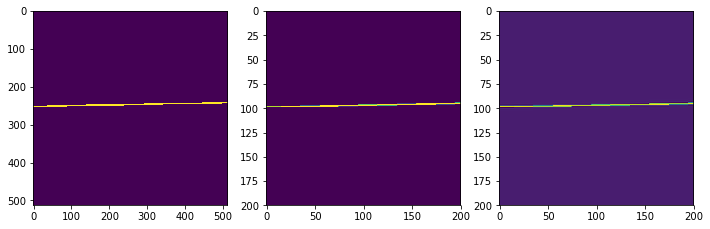

In [497]:
i1 = 13
i2 = int((float(i1)/sku_array.shape[2])*r2_sku.shape[2])

plt.figure(figsize=(16,5))
plt.subplot(141)
plt.imshow(ml_array[:,:,i1])

plt.subplot(142)
plt.imshow(Reshaped_ml[:,:,i2])

plt.subplot(143)
plt.imshow(r2_ml[:,:,i2])
plt.show()

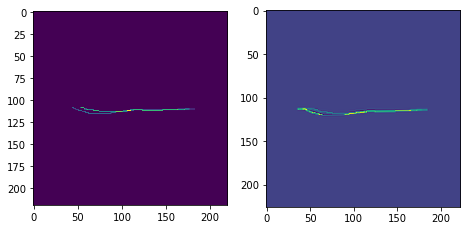

In [479]:
i = 105

plt.figure(figsize=(16,5))
plt.subplot(141)

# plt.imshow(mask[:,i,:]
plt.imshow(Reshaped_mp[:,:,i])
plt.subplot(142)
plt.imshow(r2_mp[:,:,i])
plt.show()

In [480]:
# When finding the binary mask, try to look somewhere around the average value
# make sure Binary_mask is not too coarse than the original mask
r2_mp.mean()

0.0028699806938234343

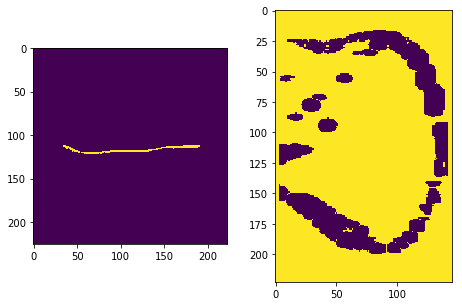

In [481]:
Binary_Mask = np.zeros(r2_mp.shape)
Binary_Mask[np.abs(r2_mp)>0.2]=1

Binary_sku  = np.zeros(r2_sku.shape)
Binary_sku[np.abs(r2_sku)>0.001] = -1

# Check the spread range of x1 value should be very small
# Calculate the reference_x coordinates
Binary_mp = np.zeros(r2_ml.shape)
Binary_mp[np.abs(r2_ml)>0.4]=1
r2_IMLq = Binary_mp
xr = np.nonzero(r2_IMLq)[0]
counts = np.bincount(xr)
reference_x = np.argmax(counts)

Skull_Contour = Binary_sku[reference_x,:,:]


plt.figure(figsize=(16,5))
plt.subplot(141)
plt.imshow(Binary_Mask[:,:,i2])

plt.subplot(142)
plt.imshow(Binary_sku[reference_x,:,:])

In [482]:
Binary_mps = np.zeros(r2_mp.shape)
Binary_mps[np.abs(r2_mp)>0.03]=1
print('number of MPS points:',len(Binary_mps[0]))

dis = np.nonzero(Binary_mps)
MPS_metrix = np.ones(Binary_mps.shape[:2]) * 100
MPS_metrix_normalized = np.zeros(Binary_mps.shape[:2])

# max_dev = float(np.max(np.abs(dis[0]-reference_x)))

coord_list = []
dic = {}
for i in range(len(dis[0])):
    if (dis[1][i],dis[2][i]) in coord_list:
        dic[(dis[1][i],dis[2][i])].append((dis[0][i]))
    else:
        coord_list.append((dis[1][i],dis[2][i]))
        dic[(dis[1][i],dis[2][i])] = [dis[0][i]]

# in dis, there might be overlapping coordinates in MPS plane due to the rotation effects
# get the mean value of those overlapping keys

for i in coord_list:
    MPS_metrix[i] = np.mean(dic[i]) - reference_x
    
MPS_metrix[MPS_metrix==100.] = np.nan

number of MPS points: 223


In [483]:
np.sum(MPS_metrix[MPS_metrix>0]),np.sum(MPS_metrix[MPS_metrix<0])

/anaconda/envs/mic3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.
/anaconda/envs/mic3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


(29960.727777777778, -1110.9976190476186)

In [484]:
np.sum(MPS_metrix>0),np.sum(MPS_metrix<0)

/anaconda/envs/mic3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.
/anaconda/envs/mic3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


(10727, 1424)

In [485]:
# Deviation to the right is positive!
# if np.sum(MPS_metrix>0) > np.sum(MPS_metrix<0):
if np.sum(MPS_metrix[MPS_metrix>0]) > np.sum(np.abs(MPS_metrix[MPS_metrix<0])):
    print('inaccuracy:', np.min(MPS_metrix))
    MPS_metrix[MPS_metrix < 0] = 0.01
    print("Midplane shift to the right hemisphere")
else:
    MPS_metrix = MPS_metrix * -1
    MPS_metrix[MPS_metrix < 0] = 0.01
    print("Midplane shift to the left hemisphere")
    
MPS_metrix_normalized = MPS_metrix/np.nanmax(MPS_metrix)
print('Average MPS length:', np.mean(MPS_metrix),'\n'
     'Max MPS deviation:', np.nanmax(MPS_metrix),'\n'
     'MPS_volume:', np.nansum(MPS_metrix)
     )

# MPS_metrix[MPS_metrix==0.] = np.nan
# MPS_metrix_normalized[MPS_metrix_normalized==0.] = np.nan

import scipy
# ww[ww==0] = np.nan
ww = scipy.ndimage.filters.gaussian_filter(MPS_metrix_normalized,0.5)
# ww[ww==0] = np.nan

Skull_Contour[np.nonzero(Skull_Contour)] = -0.2
mps_contour = ww.copy()
y,z = np.nonzero(Skull_Contour)
for i in range(len(z)):
    mps_contour[y[i]-1,z[i]-1]= Skull_Contour[y[i]-1,z[i]-1]

inaccuracy: nan
Midplane shift to the right hemisphere
Average MPS length: nan 
Max MPS deviation: 9.0 
MPS_volume: 29974.9677778


/anaconda/envs/mic3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda/envs/mic3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda/envs/mic3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """


In [486]:
np.nanmax(mps_contour),np.nanmin(ww)

(0.95826370721621346, 0.0)

<IPython.core.display.Javascript object>


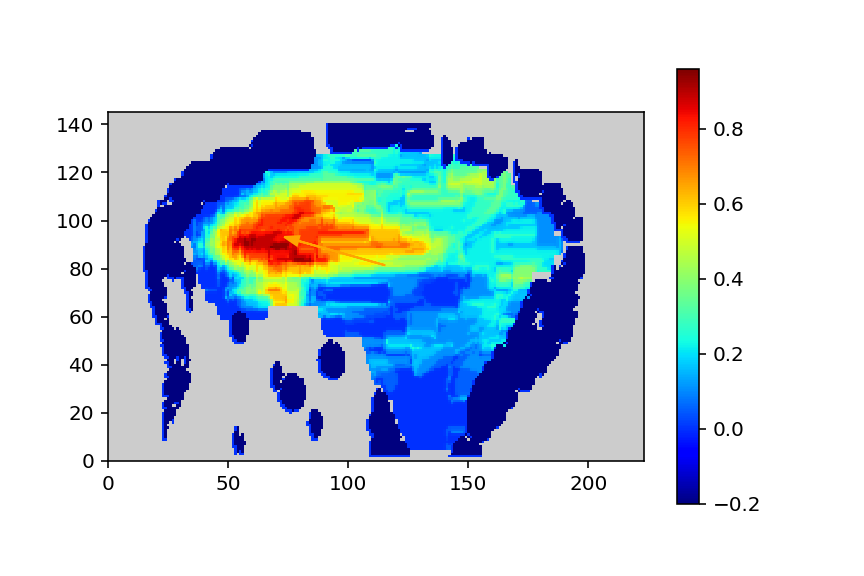

In [487]:
%matplotlib nbagg
fig, ax = plt.subplots()
# lesion_contour[lesion_contour==0]=np.nan
palette = plt.cm.jet
palette.set_bad(alpha=0.2)
heatmap = ax.imshow(mps_contour.transpose(), cmap=palette)
# heatmap = ax.imshow(MPS_metrix.transpose(), cmap=palette)
# heatmap = ax.imshow(Skull_Contour.transpose())

plt.ylim(0, Skull_Contour.shape[1])
plt.xlim (0,Skull_Contour.shape[0])
# ax.set_aspect(ConstPixelSpacing[2]/ConstPixelSpacing[1])
plt.colorbar(heatmap)
plt.show()

os.chdir(path)
plt.savefig('mps_contour.png')

In [488]:
from skimage import filters
import scipy.ndimage as ndi
from skimage.segmentation import find_boundaries as boundaries
import skimage

def region_parameter(region):
    #     Output the region parameters including centroid coordinate, 
    #     region area, length of major and minor axis
    labels = skimage.measure.label(region, connectivity=1)
    props = skimage.measure.regionprops(labels)
    v = [p.area for p in props]
    ind = np.argsort(v)
    # # From first to fourth biggest region
    #   determine whether the regions are connected or not
    n_regions = len(v)
    vcoords = props[ind[-1]].coords
    Area = v[ind[-1]]
    V_centroid = props[ind[-1]].centroid

    # The length of the major axis of the ellipse that has the same 
    # normalized second central moments as the region
    axis_major = props[ind[-1]].major_axis_length
    axis_minor = props[ind[-1]].minor_axis_length
    return n_regions,Area,V_centroid,axis_major,axis_minor

def average(xs):
    N = float(len(xs))
    return tuple(sum(col)/N for col in zip(*xs))

MPS = ww
# Region of relative MPS greater than 0.6
region06 = np.zeros(MPS.shape)
region06[MPS>0.6] = 1

# Region of relative MPS greater than 0
region0 = np.zeros(MPS.shape)
region0[MPS>0] = 1

# Region of relative MPS greater than 0.8
region08 = np.zeros(MPS.shape)
region08[MPS>0.8] = 1

# Region of relative MPS greater than 0.8
region04 = np.zeros(MPS.shape)
region04[MPS>0.4] = 1

n,Area0,Centroid0,axis_major0,axis_minor0 = region_parameter(region0)
n,Area4,Centroid4,axis_major4,axis_minor4 = region_parameter(region04)
n,Area6,Centroid6,axis_major6,axis_minor6 = region_parameter(region06)
n,Area8,Centroid8,axis_major8,axis_minor8 = region_parameter(region08)

maxMPS = np.where(ww==np.nanmax(ww))[0][0],np.where(ww==np.nanmax(ww))[1][0]



# Vectors pointing from centroid of brain to centroid of cross plane deviation
mps_centroid = average([Centroid4,Centroid6,Centroid8])

vec1 = np.subtract(mps_centroid,Centroid0)
# vec1 pointing tawards the centroid of midplane deviation
vec2 = np.subtract(maxMPS,Centroid0)
# vec2 pointing towards the max MPS deviation point


import matplotlib
x,y = Centroid0
dx,dy = vec1
wx,wy = vec2

matplotlib.pyplot.arrow(x, y, dx, dy,head_width=4,color = 'orange')


# Specify vec1 or vec2

/anaconda/envs/mic3/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in greater
/anaconda/envs/mic3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/anaconda/envs/mic3/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater
/anaconda/envs/mic3/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in greater


<IPython.core.display.Javascript object>


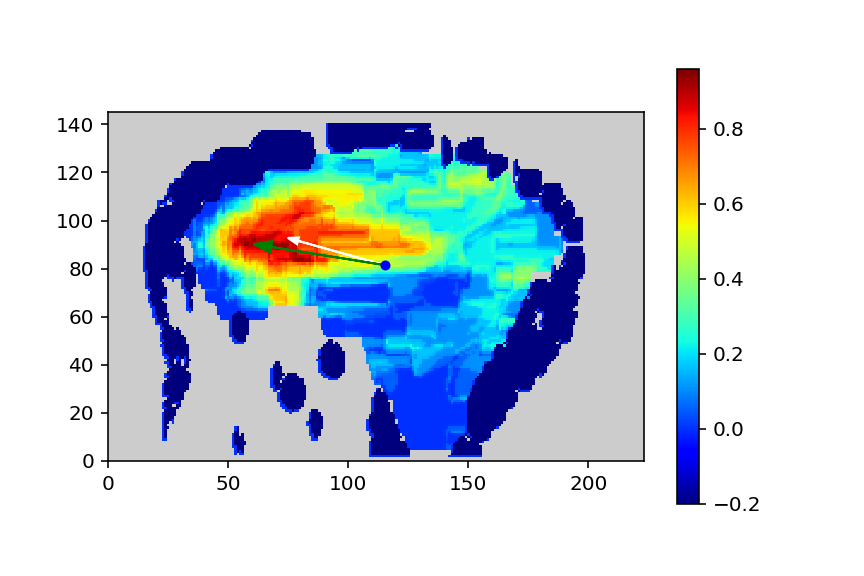

In [489]:
%matplotlib nbagg
fig, ax = plt.subplots()
palette = plt.cm.jet
palette.set_bad(alpha=0.2)
Skull_Contour[Skull_Contour==0]= np.nan
heatmap = ax.imshow(mps_contour.transpose(), cmap=palette)
# matplotlib.pyplot.arrow(x, y, dx, dy,head_width=4)
# matplotlib.pyplot.arrow(x, y, dx, dy,head_width=4)

matplotlib.pyplot.arrow(x, y, dx, dy,head_width=3,color = 'white')
# white towards centroid of MPS deviation
# green towards max MPS point
matplotlib.pyplot.arrow(x, y, wx, wy,head_width=5,color = 'green')


plt.plot([x], [y], marker='o', markersize=4, color="blue")

# heatmap = ax.imshow(lesion_contour.transpose(), cmap=palette)
# heatmap = ax.pcolor(brain_diff==0, cmap=plt.cm.winter)
plt.ylim(0, Skull_Contour.shape[1])
plt.xlim (0,Skull_Contour.shape[0])
# ax.set_aspect(ConstPixelSpacing[2]/ConstPixelSpacing[1])
plt.colorbar(heatmap)
plt.show()
os.chdir(path)
plt.savefig('mps_vecs.png')

In [492]:
# axis_pair8,axis_pair6,axis_pair4,axis_pair0 = [],[],[],[]
# area8,area6,area4,area0 =  [],[],[],[]
# maxMPS_list, centroidMPS_list,centroid_Brain = [], [],[]
# vec1_list, vec2_list = [], []
# volume = []

volume.append((np.nansum(MPS_metrix)))
vec1_list.append((vec1))
vec2_list.append((vec2))
centroid_Brain.append((Centroid0))
centroidMPS_list.append((mps_centroid))
maxMPS_list.append((maxMPS))
area8.append((Area8))
area6.append((Area6))
area4.append((Area4))
area0.append((Area0))

axis_pair8.append((axis_major8,axis_minor8))
axis_pair6.append((axis_major6,axis_minor6))
axis_pair4.append((axis_major4,axis_minor4))
axis_pair0.append((axis_major0,axis_minor0))




In [493]:
output = {'Area80%': area8, 'Area60%': area6,'Area40%':area4, 'Area_crossbrain':area0,
         'axis_80%':axis_pair8,'axis_60%':axis_pair6,'axis_40%':axis_pair4,'axis_0%':axis_pair0,
          'maxMPS_coord':maxMPS_list, 'centroidMPS_coord':centroidMPS_list,'centroid_Brain_coord':centroid_Brain,
          'mps_centroid_vec':vec1_list, 'max_mps_vec':vec2_list,'mps_volume':volume
         }
output

{'Area40%': [2730],
 'Area60%': [1528],
 'Area80%': [294],
 'Area_crossbrain': [11858],
 'axis_0%': [(153.7442151417061, 110.91700892676525)],
 'axis_40%': [(88.20404906885832, 44.35521968658598)],
 'axis_60%': [(77.235955955574, 28.69148206140429)],
 'axis_80%': [(32.94992232869999, 12.751582795904746)],
 'centroidMPS_coord': [(79.126884994835635, 91.534985566249588)],
 'centroid_Brain_coord': [(115.10937763535166, 81.441895766571093)],
 'maxMPS_coord': [(68, 89)],
 'max_mps_vec': [array([-47.10937764,   7.55810423])],
 'mps_centroid_vec': [array([-35.98249264,  10.0930898 ])],
 'mps_volume': [29974.967777777776]}

In [494]:
import pandas as pd
longlist = pd.DataFrame(data = output)
longlist

,Area80%,Area60%,Area40%,Area_crossbrain,axis_80%,axis_60%,axis_40%,axis_0%,maxMPS_coord,centroidMPS_coord,centroid_Brain_coord,mps_centroid_vec,max_mps_vec,mps_volume
0,294,1528,2730,11858,"(32.94992232869999, 12.751582795904746)","(77.235955955574, 28.69148206140429)","(88.20404906885832, 44.35521968658598)","(153.7442151417061, 110.91700892676525)","(68, 89)","(79.1268849948, 91.5349855662)","(115.109377635, 81.4418957666)","[-35.9824926405, 10.0930897997]","[-47.1093776354, 7.55810423343]",29974.967778


In [365]:
longlist.to_csv('MPS_metrics1.csv')